In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


In [67]:
data = pd.read_excel('LSTM Data\\AirQualityUCI.xlsx')
data.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [68]:
y = data[['T', 'RH', 'AH']]
y.head()

,T,RH,AH
0,13.60,48.875001,0.757754
1,13.30,47.700000,0.725487
2,11.90,53.975000,0.750239
3,11.00,60.000000,0.786713
4,11.15,59.575001,0.788794


In [69]:
# creating a new dataframe with only the 'CO(GT)	PT08.S1(CO)	NMHC(GT)	C6H6(GT)	PT08.S2(NMHC)	NOx(GT)	PT08.S3(NOx)	NO2(GT)	PT08.S4(NO2)	PT08.S5(O3)' column

x = data[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
x.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00


In [70]:
# normalizing the dataset x
scaler = MinMaxScaler(feature_range=(0, 1))
x_normalized = scaler.fit_transform(x)
y_normalized = scaler.fit_transform(y)
x_normalized.shape , y_normalized.shape

((9357, 10), (9357, 3))

In [71]:
print(x_normalized[0:3])

[[0.95611137 0.69650631 0.25197984 0.80336899 0.51594863 0.2179869
  0.43578181 0.57995183 0.63596639 0.53897714]
 [0.95327985 0.66625739 0.22462203 0.79394856 0.47835543 0.18046456
  0.4765415  0.54104132 0.59117647 0.43053898]
 [0.95422369 0.7152584  0.20734341 0.79243439 0.47193455 0.19714116
  0.46483393 0.58180471 0.5897479  0.46790928]]


In [105]:
# def sliding_windows(data, seq_length):
#     x = []
#     y = []

#     for i in range(len(data)-seq_length-1):
#         _x = data[i:(i+seq_length)]
#         _y = data[i+seq_length]
#         x.append(_x)
#         y.append(_y)

#     return np.array(x),np.array(y)

# Defining the sliding window size
seq_length = 24

# Applying the sliding window to both features and target
def create_dataset(features, target, window_size):
    dataX, dataY = [], []
    for i in range(len(features) - window_size):
        a = features[i:(i + window_size), :]
        dataX.append(a)
        dataY.append(target[i + window_size, :])
    return np.array(dataX), np.array(dataY)

seq_length = 24
X,Y = create_dataset(x_normalized,y_normalized, seq_length)
print(X[0].shape,Y[0].shape)
print(f'\t{X[0]}',f'\n\n{Y[0]}')
X.shape, Y.shape

# A,B = sliding_windows(y_normalized, seq_length)


(24, 10) (3,)
	[[0.95611137 0.69650631 0.25197984 0.80336899 0.51594863 0.2179869
  0.43578181 0.57995183 0.63596639 0.53897714]
 [0.95327985 0.66625739 0.22462203 0.79394856 0.47835543 0.18046456
  0.4765415  0.54104132 0.59117647 0.43053898]
 [0.95422369 0.7152584  0.20734341 0.79243439 0.47193455 0.19714116
  0.46483393 0.58180471 0.5897479  0.46790928]
 [0.95422369 0.70342672 0.20158387 0.79331017 0.4756628  0.22156045
  0.44818316 0.59662776 0.59957983 0.51537967]
 [0.95139217 0.65732783 0.18070554 0.78303279 0.42895609 0.19714116
  0.48738184 0.58551047 0.56806723 0.48113121]
 [0.94950448 0.62373033 0.17134629 0.77629433 0.39364126 0.17212627
  0.53299801 0.54845284 0.53546218 0.42209164]
 [0.94950448 0.61837259 0.1663067  0.77206059 0.36847556 0.15604527
  0.5764461  0.5132481  0.51521008 0.34248462]
 [0.94856064 0.59660676 0.1663067  0.77093175 0.36122618 0.15604527
  0.57349753 0.51139522 0.51521008 0.34138279]
 [0.94808872 0.57774305 0.1612671  0.76718846 0.33492129 0.1459201

((9333, 24, 10), (9333, 3))

In [106]:
# creating train and test validation sets using sklearn
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# validate the shapes of the train and test sets
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# creating validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# validating the shapes of the train and validation sets
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)




(7466, 24, 10) (7466, 3)
(1867, 24, 10) (1867, 3)
(5972, 24, 10) (5972, 3)
(1494, 24, 10) (1494, 3)


In [107]:
# reshaping input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], seq_length, 10)).astype('float32')
x_val = np.reshape(x_val, (x_val.shape[0], seq_length, 10)).astype('float32')
x_test = np.reshape(x_test, (x_test.shape[0], seq_length, 10)).astype('float32')


# reshaping output to be [samples, time steps, features]
y_train = np.reshape(y_train, (y_train.shape[0], 3)).astype('float32')
y_val = np.reshape(y_val, (y_val.shape[0], 3)).astype('float32')
y_test = np.reshape(y_test, (y_test.shape[0], 3)).astype('float32')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(5972, 24, 10) (5972, 3)
(1494, 24, 10) (1494, 3)
(1867, 24, 10) (1867, 3)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 24, 100)           44400     
                                                                 
 lstm_12 (LSTM)              (None, 24, 100)           80400     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 205,503
Trainable params: 205,503
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
94/94 [==============================] - 7s 31ms/step - loss: 0.0394 - accuracy: 0.8573 - val_loss: 0.0178 - val_accuracy: 0.9625
Epoch 2/50
94/94 [=====================

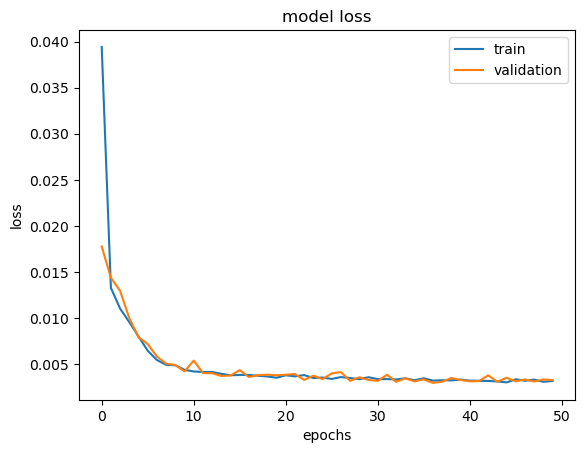

In [108]:
# creating and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(seq_length, 10), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

# fitting the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=64, verbose=1)

# ploting the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [110]:
# Adding the necessary imports for EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

num_epochs =100
batch_size=256
sequence_length = x_train.shape[1]
input_dim= x_train.shape[2]
output_dim= 3
model1 = Sequential()
model1.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, input_dim)))
# model.add(BatchNormalization())
model1.add(Dropout (0.2))
model1.add(LSTM(128, return_sequences=False, input_shape=(sequence_length, input_dim)))
# model.add(BatchNormalization())
model.add(Dropout (0.2))
# model.add(Dense(1))
model1.add((Dense (output_dim)))
model1.add(Activation("linear"))
es= EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
model1.compile(loss="mse", optimizer="adam", metrics=['mean_squared_error','mean_absolute_percentage_error']) 

model1.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 24, 64)            19200     
                                                                 
 dropout_4 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               98816     
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 118,403
Trainable params: 118,403
Non-trainable params: 0
_________________________________________________________________


In [111]:
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_val, y_val), shuffle=False)

Epoch 1/100
24/24 [==============================] - 4s 54ms/step - loss: 0.1327 - mean_squared_error: 0.1327 - mean_absolute_percentage_error: 19779320.0000 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_percentage_error: 20397610.0000
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_percentage_error: 16175053.0000 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_percentage_error: 15435442.0000
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_percentage_error: 14129498.0000 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_percentage_error: 15553095.0000
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 13695434.0000 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - va

59/59 [==============================] - 1s 7ms/step
Root Mean Squared Error (RMSE) for T, RH, AH: [15.328316 19.917866 13.543719]


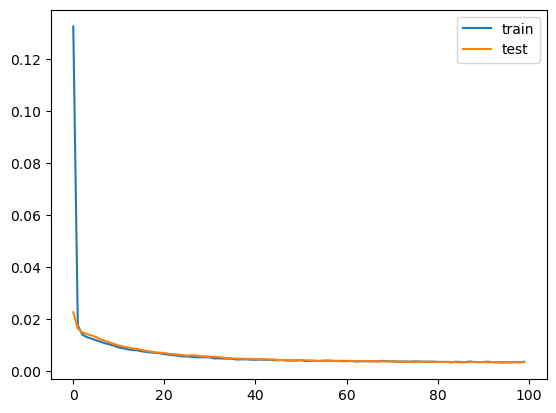

In [113]:
# Evaluating the model
y_pred = model1.predict(x_test)

# Inversing transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)


# Calculating RMSE for each output variable
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original, multioutput='raw_values'))
print("Root Mean Squared Error (RMSE) for T, RH, AH:", rmse)

# Ploting the training loss and validation loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [117]:
#  predicting the values for the test set
y_pred = model1.predict(x_test)
# inverting predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# calculating root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

# calculating mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print('Test Score: %.2f MAE' % (mae))


59/59 [==============================] - 0s 7ms/step
Test Score: 16.48 RMSE
Test Score: 5.77 MAE


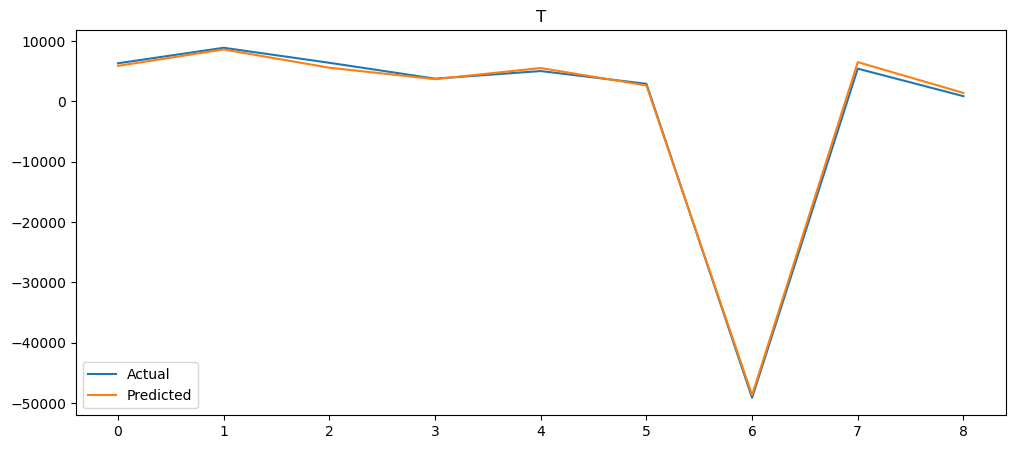

In [130]:
# Inversing transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Ploting the actual values vs the predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_test_original[0:9,0], label='Actual')
plt.plot(y_pred_original[0:9,0], label='Predicted')
plt.title('T')
plt.legend()
plt.show()


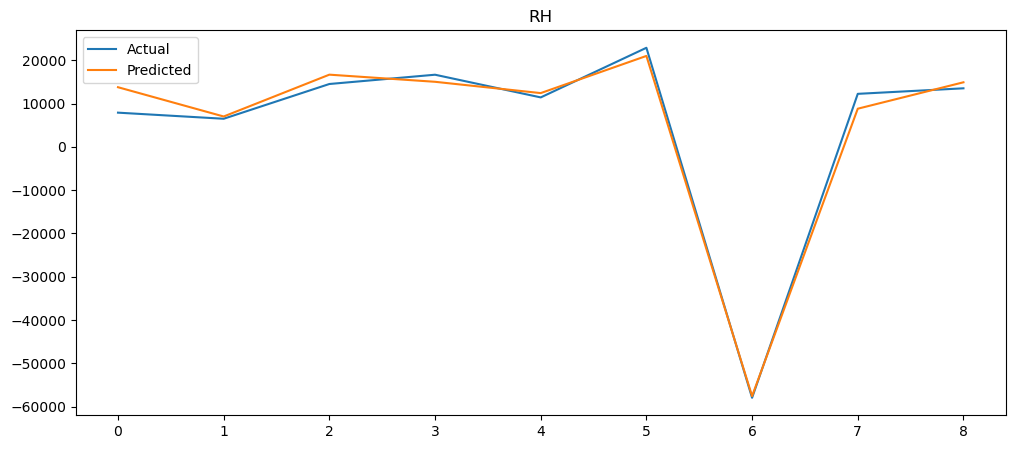

In [129]:
# Ploting the actual values vs the predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_test_original[0:9,1], label='Actual')
plt.plot(y_pred_original[0:9,1], label='Predicted')
plt.title('RH')
plt.legend()
plt.show()

